In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
################################################################################################################################################
### Graph settings

from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
#rc('font',**{'family':'','sans-serif':['DejaVu Sans'],'size':10})
rc('font', family='serif')
# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
#%config InlineBackend.figure_format = 'retina'

def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#     ax.xaxis.set_tick_params(top='off', direction='out', width=1)
#     ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
        # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
c_list = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'navy', 'gold', 'crimson', 'darkslategrey', 'orchid', 'lawngreen'
              , 'cadetblue', 'fuchsia', 'indigo', 'sienna', 'darkolivegreen']

################################################################################################################################################

In [4]:
### import os, os.path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import sys
import dask.array as da
import dask.dataframe as dd
import fnmatch # added fnmatch

### Grid Averaging

In [ ]:

### To use this file, make sure the above libraries are installed and imported 
### python dump_file_averaging.py base_case_file general_case_file
### for instance:
### python dump_file_averaging.py profile_grid_cool_fluid.dat0 profile_grid_cool_fluid.dat

base_case = r'simulations/profile_grid_cool_fluid.dat150'

file_name = base_case[:-1*len(re.split('dat',base_case)[-1])] # remove last few digits in base case to get general case

df0 = pd.read_csv(base_case # USER INPUT base_case used here
                  ,skiprows=[0,1,3], delim_whitespace=True) # base case, for columns parsing, base case is .dat0, out of 1000 files

columns_l = df0.columns[1:] # obtain columns, ignoring the '#' symbol in the datafile, raise error if format incorrect
del df0 # free up memory

directory = os.path.dirname(file_name)
fn = os.path.basename(file_name)

file_no = len(fnmatch.filter(os.listdir(directory)
                         , '{}*'.format(fn))) #added a bracket

print('No. of files:  ' + str(file_no))

print('Base case loaded')

df = dd.read_csv(file_name + r'*'
                ,skiprows=[0,1,3], delim_whitespace=True) # use dask to process all files of interest 'profile_grid_cool_fluid.dat'

print('All dataframes loaded')

df = df.iloc[:, :-1]
df.columns = columns_l # correct the columns
print('Columns corrected')

df_mean = df.groupby(df.Chunk).mean().compute()
print('Mean Calculated')
df_mean.to_csv('df_mean_parallel_grid_{}.csv'.format(file_no), sep = ' ')

# following code for calculating standard deviation can be computationally expensive
# the most demanding part of code, most likely to cause mem error
# df_std = df.groupby(df.Chunk).std().compute().add_suffix('_std') # compute std, add suffix _std
							
# df_std.to_csv('df_std_parallel_grid_{}.csv'.format(file_name), sep = ' ')

# print('Standard deviation Calculated')

# df_both = pd.concat([df_mean, df_std], axis = 1)
# df_both.to_csv('df_both_parallel_grid_{}.csv'.format(file_name), sep = ' ') # output file
print('Job saved and finished')
#os.chdir(r'../')

In [ ]:
### Alternate Method, weighted average this time

### To use this file, make sure the above libraries are installed and imported 
### python dump_file_averaging.py base_case_file general_case_file
### for instance:
### python dump_file_averaging.py profile_grid_cool_fluid.dat0 profile_grid_cool_fluid.dat

base_case = r'simulations/profile_grid_cool_fluid.dat150'

file_name = base_case[:-1*len(re.split('dat',base_case)[-1])] # remove last few digits in base case to get general case

df0 = pd.read_csv(base_case # USER INPUT base_case used here
                  ,skiprows=[0,1,3], delim_whitespace=True) # base case, for columns parsing, base case is .dat0, out of 1000 files

columns_l = df0.columns[1:] # obtain columns, ignoring the '#' symbol in the datafile, raise error if format incorrect
del df0 # free up memory

directory = os.path.dirname(file_name)
fn = os.path.basename(file_name)

file_no = len(fnmatch.filter(os.listdir(directory)
                         , '{}*'.format(fn))) #added a bracket

print('No. of files:  ' + str(file_no))

print('Base case loaded')

df = dd.read_csv(file_name + r'*'
                ,skiprows=[0,1,3], delim_whitespace=True) # use dask to process all files of interest 'profile_grid_cool_fluid.dat'

print('All dataframes loaded')

df = df.iloc[:, :-1]
df.columns = columns_l # correct the columns
print('Columns corrected')

df['temp_w'] = df['temp'] * df['density/number']
sum_weighted_temp = df['temp_w'].groupby(df.Chunk).sum().compute()
sum_weights = df['density/number'].groupby(df.Chunk).sum().compute()

df_mean = df.groupby(df.Chunk).mean().compute()
df_mean['temp'] = sum_weighted_temp / sum_weights
print('Mean Calculated')
df_mean.to_csv('df_mean_parallel_grid_{}.csv'.format(file_no), sep = ' ')

# following code for calculating standard deviation can be computationally expensive
# the most demanding part of code, most likely to cause mem error
# df_std = df.groupby(df.Chunk).std().compute().add_suffix('_std') # compute std, add suffix _std
							
# df_std.to_csv('df_std_parallel_grid_{}.csv'.format(file_name), sep = ' ')

# print('Standard deviation Calculated')

# df_both = pd.concat([df_mean, df_std], axis = 1)
# df_both.to_csv('df_both_parallel_grid_{}.csv'.format(file_name), sep = ' ') # output file
print('Job saved and finished')
#os.chdir(r'../')

In [30]:
df_fluid = df_mean

In [38]:
df_filtered = df_fluid[(df_fluid['density/number'] > 0.1)  # density filter
                      #& (df_mean['temp'] < 0.9) & (df_mean['temp'] > 0.72)
                     ]

In [39]:
lp = 4**(1/3) # lattice parameter
center_x = 4**(1/3)*(20+26) / 2 # center of fluid
center_y = 4**(1/3)*(20+26) / 2
center_z = 4**(1/3)*(20+26) / 2

In [40]:
df_filtered['x'] = df_filtered['v_vx'] - center_x 
df_filtered['y'] = df_filtered['v_vy'] - center_y
df_filtered['z'] = df_filtered['v_vz'] - center_z

<ipython-input-40-c39e4d78377a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x'] = df_filtered['v_vx'] - center_x
<ipython-input-40-c39e4d78377a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['y'] = df_filtered['v_vy'] - center_y
<ipython-input-40-c39e4d78377a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [41]:
df_filtered['R_xy'] = np.sqrt(df_filtered['y']**2 + df_filtered['z']**2)

<ipython-input-41-be2f2e26d0d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['R_xy'] = np.sqrt(df_filtered['y']**2 + df_filtered['z']**2)


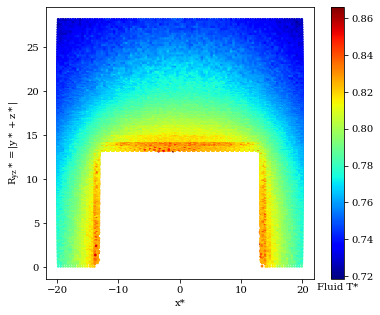

In [43]:
### illustration of fluid temperature grids
fig = plt.figure(figsize = (6, 5))#
ax = plt.axes()

sctt = ax.scatter(df_filtered['x'], df_filtered['R_xy']
     , c = df_filtered['temp']
     , cmap = 'jet', s = 3#, vmin = 0.72, vmax = 0.85
    )

cbar = fig.colorbar(sctt, ax = ax)
cbar.ax.set_xlabel('Fluid T*')

ax.set_xlabel('x*')

ax.set_ylabel(r"$R_{yz}*=|y* + z*|$")

title = 'Temp_profile_cube'
savefig('{}.jpeg'.format(title),bbox_inches='tight', dpi=1000)

### Trajectory Averaging

In [45]:
os.chdir(r'/rds/general/ephemeral/user/mj1516/ephemeral/cube')

In [46]:
base_case = r'simulations/particle_traj.traj150'

file_name = base_case[:-1*len(re.split('traj',base_case)[-1])] # remove last few digits in base case to get general case

line = 4 # 4th line is atom number
with open(base_case) as f:
    [next(f) for i in range(line-1)]
    no_atom = int(next(f))
    
directory = os.path.dirname(file_name)
fn = os.path.basename(file_name)
print('Directories Identified')
file_no = len(fnmatch.filter(os.listdir(directory)
                         , '{}*'.format(fn))) #added a bracket
print('Number of Files: {}'.format(file_no))
df = dd.read_csv(r'{}*'.format(file_name), sep = ' ', skiprows = 17 + no_atom, sample=1000000) # 17 trajectory labels that dont contribute to the data, and lammps output for t = 0 set to 0 removed
print('dataframe loaded')
columns_l = df.columns
#df = df.dropna(axis=1)
df.columns = list(columns_l[2:-1]) + ['t1','t2','t3']
df = df[columns_l[2:-1]]
print('Columns added')

df_means = df.groupby(df.id).mean().compute()
df_means.to_csv('traj_means_{}_{}.csv'.format(0, file_no)) # output the .csv file of averaged trajectory file

print('Filed Saved')

dataframe loaded
Columns added
Filed Saved


In [47]:
cols = [ 'x', 'y', 'z', 'v_xflux',
       'v_yflux', 'v_zflux', 'temp']
df_means.columns = cols

In [48]:
df_traj_ = df_means

df_traj_['vy'] = df_traj_['y']- center_x 
df_traj_['vx'] = df_traj_['x']- center_y
df_traj_['vz'] = df_traj_['z']- center_z

df_traj_['R_xy'] = np.sqrt((df_traj_['vy'])**2 + (df_traj_['vz'])**2)

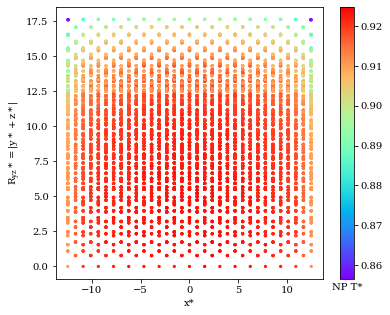

In [50]:
fig = plt.figure(figsize = (6, 5))#
ax = plt.axes()

sctt = ax.scatter(df_traj_.vx, df_traj_.R_xy, c = df_traj_.temp, cmap = 'rainbow', s = 5
        #, vmin = 0.72, vmax = 0.92
       )

cbar = fig.colorbar(sctt, ax = ax)
cbar.ax.set_xlabel('NP T*')

ax.set_xlabel('x*')

ax.set_ylabel(r"$R_{yz}*=|y* + z*|$")

title = 'Temp_profile_cube_particle'
savefig('{}.jpeg'.format(title),bbox_inches='tight', dpi=1000)

In [54]:
### save the data as a trajectory file

df_traj_.to_csv('df_traj.csv', sep = ' ')
atom_length = len(df_traj_)
with open('df_traj.csv', 'r') as original: data = original.read()
with open('df_traj.csv', 'w') as modified: modified.write(
    "ITEM: TIMESTEP \n0 \nITEM: NUMBER OF ATOMS \n{} \n\
ITEM: BOX BOUNDS ff ff ff \
     \n{} {} \n{} {} \n{} {} \nITEM: ATOMS id ".format(atom_length
                                                       , 0, center_x*2
                                                       , 0, center_y*2
                                                       , 0, center_z*2) + data)

### Ovito for alpha shapes (surface atoms are identified with selection 1) and Coordination number CN

The data from df_traj_ is analysed using the coordination analysis tool and surface-construction (alpha shapes) tool using ovito 3.5.2. The choice of coordination is for g(r), r < 1.3. Alpha radius set to 1.1.

In [56]:
### read the data processed from ovito

df_ovito = pd.read_csv(r'df_traj_ovito', sep = ' ', skiprows = 8)#.drop(columns = ['Unnamed: 0'])
columns_l = df_ovito.columns
df_ovito = df_ovito.dropna(axis=1)
df_ovito.columns = columns_l[2:]

In [57]:
df_ovito

,id,x,y,z,temp,vx,vy,vz,r_xy,fx,fy,fz,VelocityMagnitude,Coordination,selection
0,6,36.510219,36.510196,24.034512,0.910748,-0.000005,-0.000028,-12.475712,12.475712,0.017587,-0.001676,-0.051946,12.475712,8,1
1,12,34.954248,36.510200,24.034640,0.911553,-1.555976,-0.000025,-12.475584,12.475584,-0.014198,0.009321,-0.045282,12.572241,8,1
2,14,33.398164,36.510190,24.035136,0.910611,-3.112060,-0.000034,-12.475088,12.475088,-0.024623,0.001119,-0.046509,12.857400,8,1
3,15,31.842034,36.510187,24.035881,0.910804,-4.668190,-0.000037,-12.474343,12.474343,-0.017068,-0.001569,-0.044642,13.319206,8,1
4,22,30.285911,36.510190,24.036951,0.910575,-6.224313,-0.000034,-12.473273,12.473273,-0.029807,-0.005487,-0.049566,13.940036,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17964,291057,42.733963,48.970847,48.970770,0.893604,6.223739,12.460623,12.460546,17.621928,0.011118,0.091148,0.086797,18.688693,5,1
17965,291061,44.289033,48.970207,48.970012,0.893044,7.778809,12.459982,12.459787,17.620938,0.029865,0.100540,0.092192,19.261551,5,1
17966,291065,45.843273,48.969003,48.968847,0.890012,9.333049,12.458779,12.458622,17.619263,0.048748,0.096984,0.096767,19.938511,5,1
17967,291069,47.395831,48.966137,48.965959,0.886849,10.885606,12.455913,12.455735,17.615195,0.064687,0.096308,0.098867,20.707282,5,1


### Voronoi trajectory averaging

In [59]:
# import os, os.path
# import pandas as pd
# import dask.array as da
# import dask.dataframe as dd
# import sys

### To use this file, make sure the above libraries are installed and use 
### python traj_averaging.py no_atom general_case_file
### for instance:
### python traj_averaging.py 811

# args = sys.argv[1:] 
# no_atom = args[0] # USER input required here, to state the number of atoms involved
# file_name = args[1] # USER input required here, to state what the general name of the files are for averaging

file_name = r'simulations/particle_voronoi_traj.traj' # USER input required here, to state what the general name of the files are for averaging

directory = os.path.dirname(file_name)
fn = os.path.basename(file_name)
print('Directories Identified')
file_no = len(fnmatch.filter(os.listdir(directory)
                         , '{}*'.format(fn))) #added a bracket

df = dd.read_csv(r'{}*'.format(file_name), sep = ' ', skiprows = 17 + no_atom, sample=1000000) # 17 trajectory labels that dont contribute to the data, and lammps output for t = 0 set to 0 removed
print('dataframe loaded')
columns_l = df.columns
#df = df.dropna(axis=1)
df.columns = list(columns_l[2:-1]) + ['t1','t2','t3']
df = df[columns_l[2:-1]]
print('Columns added')

df_means = df.groupby(df.id).mean().compute()
df_means.to_csv('traj_voronoi_means_{}_{}.csv'.format(0, file_no)) # output the .csv file of averaged trajectory file

print('Filed Saved')

Directories Identified
dataframe loaded
Columns added
Filed Saved


In [70]:
# add the voronoi area, volume, interactions etc to the 
df_ovito['volume'] = df_means['f_atm[5]'].values
df_ovito['interactions'] = df_means['f_atm[6]'].values
df_ovito['area'] = df_means['f_atm[7]'].values

In [ ]:
### Particle border, finding temperature discontinuity

In [71]:
df_particle_border = df_ovito[df_ovito['selection'] == 1]

In [72]:
df_particle_border 

,id,x,y,z,temp,vx,vy,vz,r_xy,fx,fy,fz,VelocityMagnitude,Coordination,selection,volume,interactions,area
0,6,36.510219,36.510196,24.034512,0.910748,-0.000005,-0.000028,-12.475712,12.475712,0.017587,-0.001676,-0.051946,12.475712,8,1,1.084191,14.31584,1.559064
1,12,34.954248,36.510200,24.034640,0.911553,-1.555976,-0.000025,-12.475584,12.475584,-0.014198,0.009321,-0.045282,12.572241,8,1,1.084960,14.35229,1.561562
2,14,33.398164,36.510190,24.035136,0.910611,-3.112060,-0.000034,-12.475088,12.475088,-0.024623,0.001119,-0.046509,12.857400,8,1,1.079700,14.29525,1.561343
3,15,31.842034,36.510187,24.035881,0.910804,-4.668190,-0.000037,-12.474343,12.474343,-0.017068,-0.001569,-0.044642,13.319206,8,1,1.081907,14.33682,1.559953
4,22,30.285911,36.510190,24.036951,0.910575,-6.224313,-0.000034,-12.473273,12.473273,-0.029807,-0.005487,-0.049566,13.940036,8,1,1.081680,14.32126,1.561336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17964,291057,42.733963,48.970847,48.970770,0.893604,6.223739,12.460623,12.460546,17.621928,0.011118,0.091148,0.086797,18.688693,5,1,1.200539,14.88037,3.194495
17965,291061,44.289033,48.970207,48.970012,0.893044,7.778809,12.459982,12.459787,17.620938,0.029865,0.100540,0.092192,19.261551,5,1,1.198230,14.87922,3.187541
17966,291065,45.843273,48.969003,48.968847,0.890012,9.333049,12.458779,12.458622,17.619263,0.048748,0.096984,0.096767,19.938511,5,1,1.199464,14.89983,3.199244
17967,291069,47.395831,48.966137,48.965959,0.886849,10.885606,12.455913,12.455735,17.615195,0.064687,0.096308,0.098867,20.707282,5,1,1.198807,14.75871,3.181393


In [80]:
df_particle_border = df_particle_border.reset_index()

### Find the temperature gap $\Delta T$

In [81]:
from scipy import spatial
df_fluid_border = df_filtered

fluid_array = df_fluid_border[['x', 'y', 'z']] # can normalise the terms and add in the temperature
fluid_tree = spatial.cKDTree(fluid_array)

#df_particle_border = df_border defined

particle_array = df_particle_border[['vx', 'vy', 'vz']]
particle_tree = spatial.cKDTree(particle_array)

In [82]:
indexes = particle_tree.query_ball_tree(fluid_tree, r= 1.1 + lp/8) # maybe we know this from LJ parameter?

In [83]:
Ncount_list = []
#temp_list_std = []
for i in indexes:
    u = df_fluid_border.iloc[i]
    Ncount_list.append(sum(u.Ncount))

df_particle_border['ncount'] = Ncount_list

In [85]:
# This is for finding Delta T

from statsmodels.stats.weightstats import DescrStatsW

temp_list = []
temp_list_std = []
for i in indexes:
    u = df_fluid_border.iloc[i]
    #avg_t = np.average(u.temp, weights=u.Ncount)
    #temp_list.append(avg_t)
    
    weighted_stats = DescrStatsW(u.temp, weights=u.Ncount, ddof=0)
    temp_list.append(weighted_stats.mean)
    
df_particle_border['fluid_temp'] = temp_list

### Finding $\nabla T$ (temperature gradient) and $J_{q}$ (heat flux)

In [95]:
df_filtered = df_filtered.reset_index()
df_filtered['Coordination'] = 0

In [97]:
df_traj_['Ncount'] = 1 # each node on the NP dataframe represents 1 atom

In [105]:
df_traj_['x'] = df_traj_['vx'].values
df_traj_['y'] = df_traj_['vy'].values
df_traj_['z'] = df_traj_['vz'].values

In [106]:
df0 = df_traj_[['x','y','z','temp', 'Ncount']]
df1 = df_filtered[['x','y', 'z', 'temp', 'Ncount']]
### this is to create a combined dataframe of both solid NP nodes and fluid grods
temp_net = pd.concat([df0,df1])

In [107]:
temp_net.to_csv('temp.csv')

In [109]:
x = temp_net['x'].values
y = temp_net['y'].values
z = temp_net['z'].values
data = temp_net['temp'].values
Ncount = temp_net['Ncount'].values

In [110]:
from scipy.interpolate import LinearNDInterpolator
# a multivariate interpoaltor is used to interpolate both the number of atoms N and also the 

In [111]:
interp = LinearNDInterpolator(list(zip(x, y, z)), data) # Temperature interpolation

interp_Ncount = LinearNDInterpolator(list(zip(x, y, z)), Ncount) # Number of atoms interpolation

In [169]:
(min(x) - max(x))/0.2 # each of the new mesh grid should be space 0.2 apart, so this function is used to tell how many grids to make

-198.45721354581676

In [115]:
linx = linspace(min(x), max(x), 199) # create the meshgrid
liny = linspace(min(y), max(y), 199)
linz = linspace(min(z), max(z), 199)

In [118]:
xx,yy,zz = np.meshgrid(linx,liny,linz)

Z = interp(xx, yy, zz)
ncount = interp_Ncount(xx, yy, zz) # plugging the meshgrid into the interpolation gives an output meshgrid

dtdy, dtdx, dtdz= np.gradient(Z, np.diff(linx)[0], np.diff(liny)[0], np.diff(linz)[0], edge_order =2) 
# creates a gradient. Numpy has this weird thing where x and y are reversed

In [ ]:
### Dataframe stores the information from the meshgrid

In [119]:
dim = xx.shape[0] * xx.shape[1] * xx.shape[2]
xxx = xx.reshape(dim )
yyy = yy.reshape(dim )
zzz = zz.reshape(dim )
ZZ = Z.reshape(dim )
DTDX = dtdx.reshape(dim )
DTDY = dtdy.reshape(dim )
DTDZ = dtdz.reshape(dim )
norm = np.sqrt(DTDX**2 + DTDY**2 + DTDZ**2)

df_swopper = pd.DataFrame([])

df_swopper['x'] = xxx
df_swopper['y'] = yyy
df_swopper['z'] = zzz
df_swopper['temp'] = ZZ #DTDX
df_swopper['norm'] = norm #DTDX
df_swopper['fx'] = DTDX / norm
df_swopper['fy'] = DTDY / norm
df_swopper['fz'] = DTDZ / norm
df_swopper['Ncount'] = ncount.reshape(dim )
df_swopper['DisplacementX'] = DTDX 
df_swopper['DisplacementY'] = DTDY
df_swopper['DisplacementZ'] = DTDZ


In [120]:
from scipy import spatial
df_fluid_border = df_swopper

fluid_array = df_fluid_border[['x', 'y', 'z']] # can normalise the terms and add in the temperature
fluid_tree = spatial.cKDTree(fluid_array)

#df_particle_border = df_border defined

particle_array = df_particle_border[['vx', 'vy', 'vz']]
particle_tree = spatial.cKDTree(particle_array)

indexes = particle_tree.query_ball_tree(fluid_tree, r= 1.0) # maybe we know this from LJ parameter?

In [ ]:
# Particles on the NP surface are assigned a value of the temperlature gradient \nabla T based on the surrounding grids using a kd-tree search

In [121]:
    dtdx = []
    dtdy = []
    dtdz = []
    displacement = []
    for index,i in enumerate(indexes):
    #temp_list_std = []
        test_particle = df_particle_border.iloc[index]
        px = test_particle.x
        py = test_particle.y
        pz = test_particle.z
        u = df_fluid_border.iloc[i].reset_index()
        u['displacement'] = ((u.x.values - px)**2 + (u.y.values - py)**2 + (u.z.values - pz)**2) ** 0.5
        
        #avg_t = np.average(u.temp, weights=u.Ncount)
        #temp_list.append(avg_t) # DisplacementX	DisplacementY	DisplacementZ160	DisplacementZ

        #weighted_stats = DescrStatsW(u.temp, weights=u.Ncount, ddof=0)
        weighted_stats = DescrStatsW(u.DisplacementX, weights=u.Ncount, ddof=0)
        dtdx.append(weighted_stats.mean)
        #temp_list_std.append(weighted_stats.std)

        weighted_stats = DescrStatsW(u.DisplacementY, weights=u.Ncount, ddof=0)
        dtdy.append(weighted_stats.mean)
        #temp_list_std.append(weighted_stats.std)

        weighted_stats = DescrStatsW(u.DisplacementZ, weights=u.Ncount, ddof=0)
        dtdz.append(weighted_stats.mean)


    #Ncount_list = []
    #temp_list_std = []
    #for i in indexes:
       # u = df_fluid_border.iloc[i]
       # Ncount_list.append(sum(u.Ncount))
        


In [126]:
df_particle_border['DisplacementX'] = -array(dtdx)
df_particle_border['DisplacementY'] = -array(dtdy)
df_particle_border['DisplacementZ'] = -array(dtdz)

In [123]:
df_particle_border.to_csv('df_particle_border_june.csv')

In [128]:
df_particle_border

,index,id,x,y,z,temp,vx,vy,vz,r_xy,...,volume,interactions,area,ncount,fluid_temp,DisplacementX,DisplacementY,DisplacementZ,dis_norm,rflux_dt
0,0,6,36.510219,36.510196,24.034512,0.910748,-0.000005,-0.000028,-12.475712,12.475712,...,1.084191,14.31584,1.559064,2.584111,0.823601,-0.000418,0.000062,-0.043533,0.043535,0.051772
1,1,12,34.954248,36.510200,24.034640,0.911553,-1.555976,-0.000025,-12.475584,12.475584,...,1.084960,14.35229,1.561562,2.486803,0.823540,0.000679,0.000145,-0.043301,0.043306,0.045084
2,2,14,33.398164,36.510190,24.035136,0.910611,-3.112060,-0.000034,-12.475088,12.475088,...,1.079700,14.29525,1.561343,2.522818,0.824257,-0.000433,-0.000009,-0.042820,0.042822,0.046755
3,3,15,31.842034,36.510187,24.035881,0.910804,-4.668190,-0.000037,-12.474343,12.474343,...,1.081907,14.33682,1.559953,2.512628,0.822342,-0.000517,-0.000019,-0.044216,0.044219,0.044839
4,4,22,30.285911,36.510190,24.036951,0.910575,-6.224313,-0.000034,-12.473273,12.473273,...,1.081680,14.32126,1.561336,2.494853,0.820049,-0.000240,-0.000111,-0.045494,0.045495,0.049736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3069,17964,291057,42.733963,48.970847,48.970770,0.893604,6.223739,12.460623,12.460546,17.621928,...,1.200539,14.88037,3.194495,3.915573,0.804794,0.000565,0.038567,0.039617,0.055292,0.125880
3070,17965,291061,44.289033,48.970207,48.970012,0.893044,7.778809,12.459982,12.459787,17.620938,...,1.198230,14.87922,3.187541,3.927142,0.803210,0.001365,0.039240,0.039127,0.055431,0.136985
3071,17966,291065,45.843273,48.969003,48.968847,0.890012,9.333049,12.458779,12.458622,17.619263,...,1.199464,14.89983,3.199244,3.851511,0.799767,0.002419,0.039999,0.039756,0.056448,0.138966
3072,17967,291069,47.395831,48.966137,48.965959,0.886849,10.885606,12.455913,12.455735,17.615195,...,1.198807,14.75871,3.181393,3.898965,0.796238,0.005977,0.039538,0.039520,0.056221,0.144104


### Determining the Conductance G

In [129]:
df_particle_border['dt'] = df_particle_border.temp - df_particle_border.fluid_temp # temperature gap calculated

In [130]:
dot_dis = np.multiply(df_particle_border[['DisplacementX', 'DisplacementY', 'DisplacementZ']].values
                      , df_particle_border[['DisplacementX', 'DisplacementY', 'DisplacementZ']].values) # Projecting J on \nabla T for J_q
dis_norm = np.sqrt(array([np.sum(i) for i in dot_dis]))
df_particle_border['dis_norm'] = dis_norm
#ylim(0,11)

a = np.multiply(df_particle_border[['fx', 'fy', 'fz']].values, df_particle_border[['DisplacementX', 'DisplacementY', 'DisplacementZ']].values)
rflux_norm = array([np.sum(i) for i in a]) / df_particle_border.dis_norm
df_particle_border['rflux_dt'] = rflux_norm
df_particle_border['g_dt'] = df_particle_border.rflux_dt / df_particle_border.dt /df_particle_border.volume

In [132]:
df_particle_border['r'] = np.sqrt(df_particle_border.vx**2 + df_particle_border.vy**2 + df_particle_border.vz**2)

In [8]:
df_particle_border['r_round'] = round(df_particle_border.r, 2).values # group similar atoms together based on radial distance and coordination number
a = df_particle_border.groupby(['r_round', 'Coordination'])
df_border_mean = a.mean().reset_index()
df_border_std = a.std().reset_index()

df_border_mean['size'] = a.size().values

In [135]:
np.unique(df_particle_border.Coordination)

array([3, 5, 8])

In [155]:
np.mean(df_particle_border.Coordination)

7.811320754716981

In [5]:
coord = [3,5,8]
c_list = ['maroon', 'red', 'blue']

In [12]:
figsize(5,5)

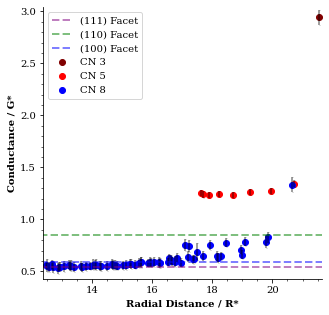

In [13]:
fig, ax = plt.subplots()
for i,j in zip(coord,c_list):
    df = df_border_mean[df_border_mean['Coordination'] == i]
    df_std = df_border_std[df_border_mean['Coordination'] == i]
    
    errorbar(df['r_round']
            , df['g_dt'],
             yerr = df_std['g_dt']
             ,color='black', ls='', marker='o', capsize=0.5, capthick=0.5, ecolor='black', markersize = 0.01
            , alpha = 0.5)
    
    ax.scatter(df['r_round']
            , df['g_dt']
            , c = j
            #, cmap = 'rainbow_r'
            #, s =df['size'] 
            , alpha = 1
            , label = 'CN {}'.format(i)
                 )
ylabel('Conductance / G*', fontweight ='bold')
xlabel('Radial Distance / R*', fontweight ='bold')

# plot([-1, 16], [0.668, 0.668], linewidth = 2, alpha = 0.5, ls = '--', label = 'Harmonic Mean', c= 'gray')
plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
     , [0.541, 0.541], linewidth = 2, alpha = 0.5, ls = '--', label = '(111) Facet', c= 'purple')
plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
     , [0.853, 0.853], linewidth = 2, alpha = 0.5, ls = '--', label = '(110) Facet', c = 'green')
plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
     , [0.594, 0.594], linewidth = 2, alpha = 0.5, ls = '--', label = '(100) Facet', c = 'blue')
minorticks_on()

stylize_axes(ax)
crit = 12
#plot([crit,crit], [min(df_border_mean['r_round'] - 0.1), max(df_border_mean['g_dt']) + 0.1], linewidth = 5 , c = 'gray', alpha = 0.5, label = 'Cylinder-Cap Boundary')
ylim(min(df_border_mean['g_dt']) - 0.1, max(df_border_mean['g_dt']) + 0.1)
xlim(min(df_border_mean['r_round']) - 0.1, max(df_border_mean['r_round']) + 0.1)

legend(loc='upper left')

title = 'Radial_Conductance_cube'
savefig('{}.svg'.format(title),bbox_inches='tight')
plt.savefig('{}.pdf'.format(title),bbox_inches='tight')

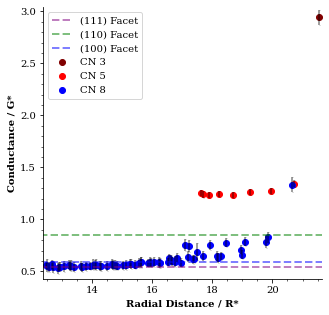

In [14]:
fig, ax = plt.subplots()
for i,j in zip(coord,c_list):
    df = df_border_mean[df_border_mean['Coordination'] == i]
    df_std = df_border_std[df_border_mean['Coordination'] == i]
    
    errorbar(df['r_round']
            , df['g_dt'],
             yerr = df_std['g_dt']
             ,color='black', ls='', marker='o', capsize=0.5, capthick=0.5, ecolor='black', markersize = 0.01
            , alpha = 0.5)
    
    ax.scatter(df['r_round']
            , df['g_dt']
            , c = j
            #, cmap = 'rainbow_r'
            #, s =df['size'] 
            , alpha = 1
            , label = 'CN {}'.format(i)
                 )
ylabel('Conductance / G*', fontweight ='bold')
xlabel('Radial Distance / R*', fontweight ='bold')

# plot([-1, 16], [0.668, 0.668], linewidth = 2, alpha = 0.5, ls = '--', label = 'Harmonic Mean', c= 'gray')
plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
     , [0.541, 0.541], linewidth = 2, alpha = 0.5, ls = '--', label = '(111) Facet', c= 'purple')
plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
     , [0.853, 0.853], linewidth = 2, alpha = 0.5, ls = '--', label = '(110) Facet', c = 'green')
plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
     , [0.594, 0.594], linewidth = 2, alpha = 0.5, ls = '--', label = '(100) Facet', c = 'blue')
minorticks_on()

stylize_axes(ax)
crit = 12
#plot([crit,crit], [min(df_border_mean['r_round'] - 0.1), max(df_border_mean['g_dt']) + 0.1], linewidth = 5 , c = 'gray', alpha = 0.5, label = 'Cylinder-Cap Boundary')
ylim(min(df_border_mean['g_dt']) - 0.1, max(df_border_mean['g_dt']) + 0.1)
xlim(min(df_border_mean['r_round']) - 0.1, max(df_border_mean['r_round']) + 0.1)

legend(loc='upper left')

# title = 'Radial_Conductance_coh'
# savefig('Radial_Conductance_coh.svg',bbox_inches='tight')
#plt.savefig('{}.pdf'.format(title),bbox_inches='tight')

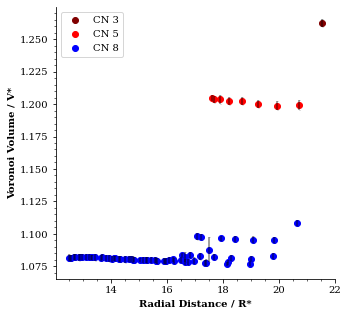

In [15]:
fig, ax = plt.subplots()
for i,j in zip(coord,c_list):
    df = df_border_mean[df_border_mean['Coordination'] == i]
    df_std = df_border_std[df_border_mean['Coordination'] == i]
    
    errorbar(df['r_round']
            , df['volume'],
             yerr = df_std['volume']
             ,color='black', ls='', marker='o', capsize=0.5, capthick=0.5, ecolor='black', markersize = 0.01
            , alpha = 0.5)
    
    ax.scatter(df['r_round']
            , df['volume']
            , c = j
            #, cmap = 'rainbow_r'
            #, s =df['size'] 
            , alpha = 1
            , label = 'CN {}'.format(i)
                 )
ylabel('Voronoi Volume / V*', fontweight ='bold')
xlabel('Radial Distance / R*', fontweight ='bold')

# plot([-1, 16], [0.668, 0.668], linewidth = 2, alpha = 0.5, ls = '--', label = 'Harmonic Mean', c= 'gray')
# plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
#      , [0.541, 0.541], linewidth = 2, alpha = 0.5, ls = '--', label = '{111} Facet', c= 'purple')
# plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
#      , [0.853, 0.853], linewidth = 2, alpha = 0.5, ls = '--', label = '{110} Facet', c = 'green')
# plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
#      , [0.594, 0.594], linewidth = 2, alpha = 0.5, ls = '--', label = '{100} Facet', c = 'blue')
minorticks_on()

stylize_axes(ax)
crit = 12
#plot([crit,crit], [min(df_border_mean['r_round'] - 0.1), max(df_border_mean['g_dt']) + 0.1], linewidth = 5 , c = 'gray', alpha = 0.5, label = 'Cylinder-Cap Boundary')
# ylim(min(df_border_mean['g_dt']) - 0.1, max(df_border_mean['g_dt']) + 0.1)
# xlim(min(df_border_mean['r_round']) - 0.1, max(df_border_mean['r_round']) + 0.1)

legend(loc='upper left')

title = 'Voronoi_volume'
savefig('{}.svg'.format(title),bbox_inches='tight')
plt.savefig('{}.pdf'.format(title),bbox_inches='tight')

In [167]:
# fig, ax = plt.subplots()
# for i,j in zip(coord,c_list):
#     df = df_border_mean[df_border_mean['Coordination'] == i]
#     df_std = df_border_std[df_border_mean['Coordination'] == i]
    
#     errorbar(df['r_round']
#             , df['ncount'],
#              yerr = df_std['ncount']
#              ,color='black', ls='', marker='o', capsize=0.5, capthick=0.5, ecolor='black', markersize = 0.01
#             , alpha = 0.5)
    
#     ax.scatter(df['r_round']
#             , df['ncount']
#             , c = j
#             #, cmap = 'rainbow_r'
#             , s =df['size'] 
#             , alpha = 1
#             , label = 'CN {}'.format(i)
#                  )
# ylabel('Conductance / G*', fontweight ='bold')
# xlabel('Radial Distance / R*', fontweight ='bold')

# # plot([-1, 16], [0.668, 0.668], linewidth = 2, alpha = 0.5, ls = '--', label = 'Harmonic Mean', c= 'gray')
# # plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
# #      , [0.541, 0.541], linewidth = 2, alpha = 0.5, ls = '--', label = '{111} Facet', c= 'purple')
# # plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
# #      , [0.853, 0.853], linewidth = 2, alpha = 0.5, ls = '--', label = '{110} Facet', c = 'green')
# # plot([min(df_border_mean['r_round']) - 0.2, max(df_border_mean['r_round']) + 0.2]
# #      , [0.594, 0.594], linewidth = 2, alpha = 0.5, ls = '--', label = '{100} Facet', c = 'blue')
# minorticks_on()

# stylize_axes(ax)
# crit = 12
# #plot([crit,crit], [min(df_border_mean['r_round'] - 0.1), max(df_border_mean['g_dt']) + 0.1], linewidth = 5 , c = 'gray', alpha = 0.5, label = 'Cylinder-Cap Boundary')
# # ylim(min(df_border_mean['g_dt']) - 0.1, max(df_border_mean['g_dt']) + 0.1)
# # xlim(min(df_border_mean['r_round']) - 0.1, max(df_border_mean['r_round']) + 0.1)

# legend(loc='upper left')

# # title = 'Radial_Conductance_coh'
# # savefig('Radial_Conductance_coh.svg',bbox_inches='tight')
# #plt.savefig('{}.pdf'.format(title),bbox_inches='tight')

### Average Conductances: AMean and HMean

In [154]:
from uncertainties import unumpy
total = np.sum(df_border_mean['size'])
divide = df_border_mean['size'] / unumpy.uarray(df_border_mean.g_dt, df_border_std.g_dt)
print('hmean:')
print(total / np.sum(divide))
print('mean:')
print(
    np.sum(df_border_mean['size'] * unumpy.uarray(df_border_mean.g_dt, df_border_std.g_dt)) / total
)

hmean:
0.622+/-0.007
mean:
0.656+/-0.006


In [156]:
np.mean(df_particle_border.Coordination)

7.811320754716981

In [160]:
### saving the results

In [164]:
df_particle_border = df_particle_border.set_index('id')

In [165]:
df_particle_border.to_csv('df_particle_border.csv', sep = ' ')
atom_length = len(df_particle_border)
with open('df_particle_border.csv', 'r') as original: data = original.read()
with open('df_particle_border.csv', 'w') as modified: modified.write(
    "ITEM: TIMESTEP \n0 \nITEM: NUMBER OF ATOMS \n{} \n\
ITEM: BOX BOUNDS ff ff ff \
     \n{} {} \n{} {} \n{} {} \nITEM: ATOMS ".format(atom_length
                                                       , 0, center_x*2
                                                       , 0, center_y*2
                                                       , 0, center_z*2) + data)

In [6]:
### read the data processed from ovito

df_particle_border = pd.read_csv(r'df_particle_border.csv', sep = ' ', skiprows = 8)#.drop(columns = ['Unnamed: 0'])
columns_l = df_particle_border.columns
df_particle_border = df_particle_border.dropna(axis=1)
df_particle_border.columns = columns_l[2:]